`father-son` 데이터 셋은 아버지와 아들의 키를 조사한 데이터셋이다. 아버지의 키가 아들의 키에 영향을 주는지 분석하고 결과를 보고하시오.

In [1]:
origin = load_data('father-son')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/father-son.xlsx
[desc] 아버지와 아들의 키를 조사한 데이터 (출처: https://www.kaggle.com/datasets/aungdev/pearson-dataset-heights-of-fathers-and-their-sons)

field    description
-------  -------------------
fheight  아버지의 키(Inches)
sheight  아들의 키(Inches)


===== 데이터 크기 확인 =====
데이터셋 크기: (1078, 2)
열 갯수: 2
행 갯수: 1078

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fheight  1078 non-null   float64
 1   sheight  1078 non-null   float64
dtypes: float64(2)
memory usage: 17.0 KB
None


,fheight,sheight
0,65.04851,59.77827
1,63.25094,63.21404
2,64.95532,63.34242
3,65.75250,62.79238
4,61.13723,64.28113



====== 이상치 확인 ======
이상치 존재 -> correlation coefficient: Spearman


,original_skew,log_skew,outliers(|z| > 3)
fheight,-0.088268,-1.155431,1.0
sheight,-0.036696,-1.401806,10.0


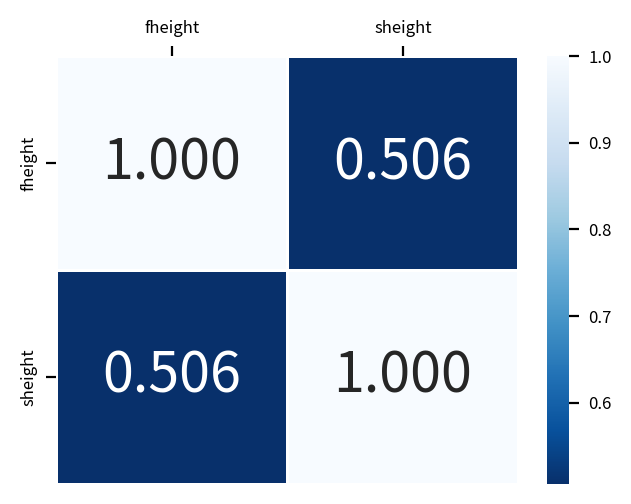

본 분석에서는 fheight과 sheight간 상관관계를 검토하였다.

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.506, p = 0.000(으)로 나타나 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [2]:
xname = 'fheight'
yname = 'sheight'

# ------------------------------------
# 선형성 가정 확인:
# ------------------------------------
# 1. 선형성: 산점도 그래프 시각화로 이미 확인함.
linearity_ok = True

# ------------------------------------
# 2. 이상치와 왜도:

data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산:
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3):
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그변환 후 왜도 계산 (음수 대비 +1):
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }

results_df = DataFrame(results).T

# 이상치 점검 결과:
outlier_flag = len(results_df['outliers(|z| > 3)'] > 0) > 0

print("\n====== 이상치 확인 ======")
print(f"{'이상치 존재 -> correlation coefficient: Spearman' if outlier_flag else '이상치 존재 X -> correlation coefficient: Pearson'}")
display(results_df)
# ------------------------------------
# 상관분석 수행
# ------------------------------------
report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

# 상관계수 선택:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.\n\n분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관" if corr > 0 else "음의 상관"} 관계가 함을 확인하였다."

else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.\n\n분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조" if corr > 0 else "음의 단조"} 관계가 존재함을 확인하였다."
    
# ------------------------------------
# 결과 시각화
# ------------------------------------
corr_matrix = origin[[xname, yname]].corr(method=chosen)

# 1) 그래프 초기화
width_px = 650              # 그래프 가로크기
height_px = 500             # 그래프 세로크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) Heatmap 그리기
sb.heatmap(data = corr_matrix, annot=True, fmt='0.3f', 
           linewidth = 0.5, cmap = "Blues_r", 
           annot_kws = {'size': 20})
  # camp: 칼라맵 종류: 'Greys', 'Purples', 'Blues', 'Greens', 
  # 'Oranges', 'Reds' / 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
  # 'RdPu', 'BuPu' / 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 
  # 'BuGn', 'YlGn' / 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 
  # 'RdBu', 'RdYlBu' / 'RdYlGn', 'Spectral', 'coolwarm', 
  # 'bwr', 'seismic' / 'berlin', 'managua', 'vanimo'

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()        # x축 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료

# ------------------------------------
# 결과 보고 출력
# ------------------------------------
print(report)

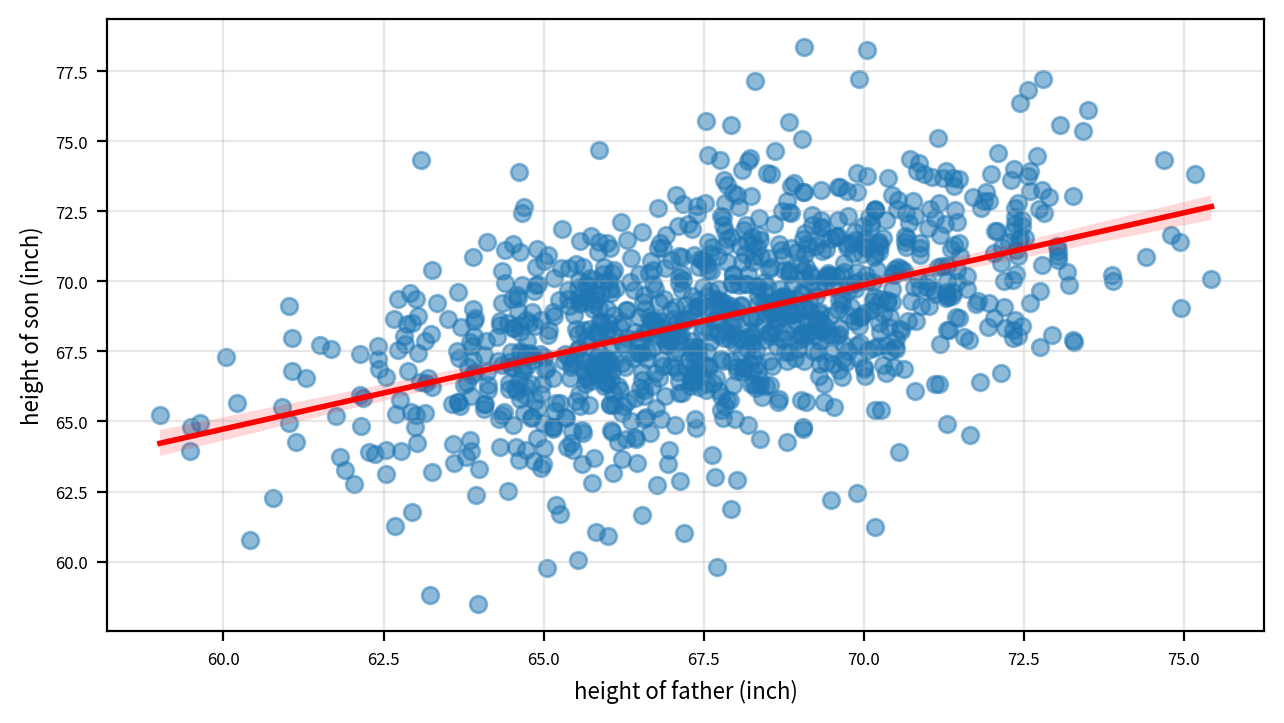

In [4]:
# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 산점도 그래프(Reg Plot) 그리기 (회귀선 포함)
    # regplot()은 hue 파라미터를 지원 안한다 ㅠ
sb.regplot(data = origin, x = 'fheight', y = 'sheight',
           scatter_kws = {'alpha': 0.5},
           line_kws={'color': 'red', 'linewidth': 2})

# 3) 그래프 꾸미기: 
ax.set_xlabel('height of father (inch)', fontsize=8)
ax.set_ylabel('height of son (inch)', fontsize=8)
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

                            OLS Regression Results                            
Dep. Variable:                sheight   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     361.2
Date:                   목, 11 12 2025   Prob (F-statistic):           1.12e-69
Time:                        11:57:57   Log-Likelihood:                -2488.7
No. Observations:                1078   AIC:                             4981.
Df Residuals:                    1076   BIC:                             4991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8866      1.832     18.493      0.0

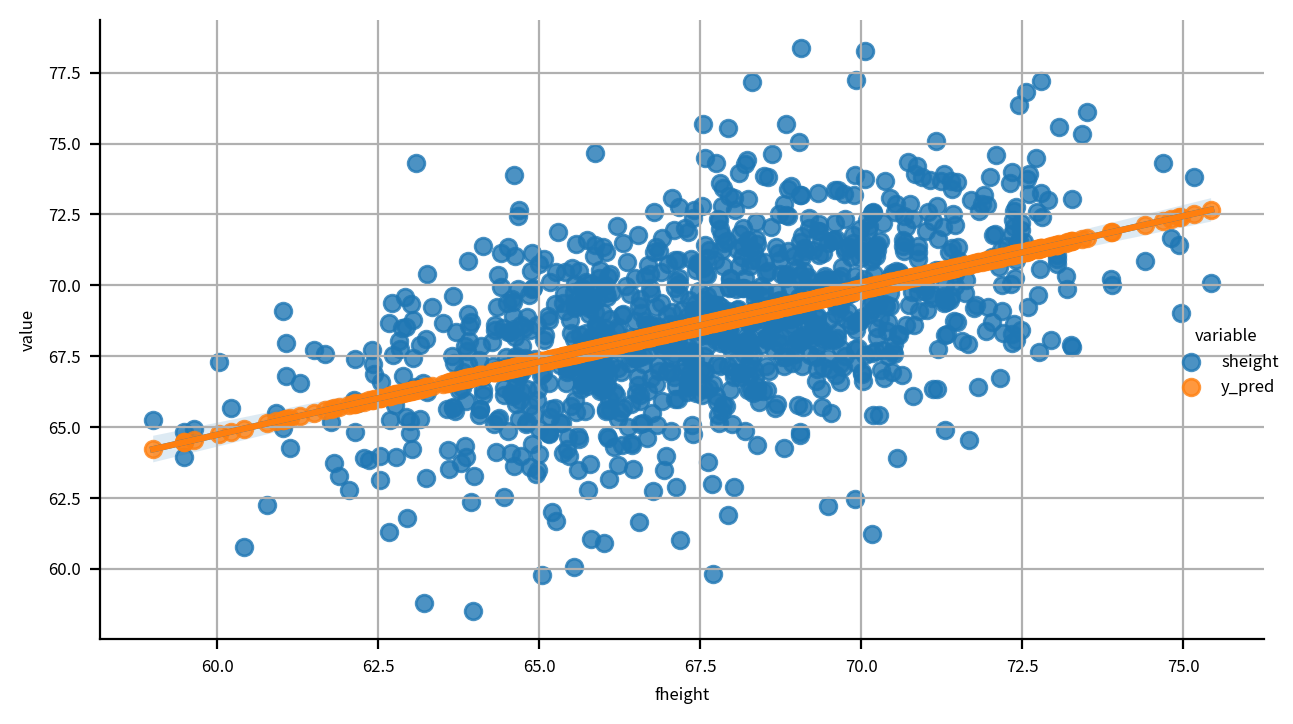

In [5]:
xname = 'fheight'
yname = 'sheight'

# ----------------------------------------
# 회귀분석 수행
# ----------------------------------------
x = origin[[xname]]
y = origin[yname]
X = sm.add_constant(x)

# OLS 모델 객체 생성
# -> 이 단계에선 학습(fit)전 '모델의 틀'만 만들어짐
model = sm.OLS(y, X)

# 모델 적합(Fit)
# -> 데이터와 객체 기능 이용해서 회귀계수(β) 추정하고, 모델을 완성시키는 단계
fit = model.fit()

# 적합된 모델 객체의 분석 결과 확인:
print(fit.summary())

# ----------------------------------------
# 모형 예측값 얻기
# ----------------------------------------
df = origin.copy()
df['y_pred'] = fit.predict(X)

df_melt = df.melt(
    id_vars = xname,
    value_vars = [yname, 'y_pred'],
    var_name = 'variable',
    value_name = 'value'
)

# ----------------------------------------
# 예측모형 시각화
# ----------------------------------------
# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) Lm Plot 그래프 그리기
# 하위 집단이 여러개 이므로 그래프 꾸미기가 필요
    # -> .lmplot() 메서드로부터 리턴되는 객체 ('g')를 활용해야함

# 한 그래프 안에 다 넣어서 보고자 할 때:
g = sb.lmplot(data = df_melt, hue = 'variable', x = xname, y = 'value')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료

**회귀 분석의 결과 보고**

1. 예측모형:
   - `height = 0.5141 x fheight + 33.8866`

2. 모형 적합도
   - 모형 유의성: 
     - **F(1, 1076) = 361.2, p < 0.001, R² = 0.251**
     - `sheight`를 종속변수로, `fheight`를 독립변수로 설정한 단순회귀분석 결과, 모형은 통계적으로 유의미하였다.
   - 모형의 설명력:
     - 그러나 `fheight`는 `sheight`의 약 **25.1%**만을 설명하는 것으로 나타났는데 이는 아들의 키를 설명하기에는 아버지의 키 이외에 다른 요인의 존재 가능성을 의미한다.

3. 독립변수
    - 독립변수의 유의성:
      - **β = 0.51, t(1076) = 19.0, p < 0.001**
      - `fheight`의 회귀계수는 **β = 0.51**로 나타났으며, 이는 `sheight`에 유의미하게 정(+)적 영향을 미쳤다.
      - `fheight`가 1 증가할 때 `sheight`는 평균적으로 **0.51** 증가하는 것으로 해석된다.